# Machine Learning Project Stage 2
I'm trying to predict the global video game sales based on the its release platform, release year, genre and game publisher. During step 1 I prepare the data for the machine learning task by cleaning the data. In step 2 I split my dataset into smaller training, cross-validation and test sets. In step 3 I train multiple models and perform cross-validation to see which one performs the best. Then in step 4 I pick the best model and get the test accuracy of the model. Finally, I conclude the results of my study and give my thoughts about the results.

### Step 0: Download Packages

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, HuberRegressor, Ridge, Lasso
from sklearn.metrics import mean_squared_error

# For seeding
random_state = 0

### Step 1: Data fetch and manipulation
I first have to do a little bit of data manipulation with my dataset.

1. Get rid off rows with NaN-values.
2. Leave out top 20 games with the greatest global sales since these are clear outliers and not explained by the data
3. Get rid off rows whose publisher is not part of the top 50 publishers.
4. Get rid off rows whose platform is not part of the top 20 most popular platforms
5. Get rid off extra columns (incl. rank, local sales)
6. Choose the feature columns and create "dummy" columns which have a 1 if the row has that feature, else 0
7. Create X, y and names dataframes

In [2]:
# 1. Import the dataset, drop rows with na-values
df = pd.read_csv("vgsales.csv", sep=",", header=0)
df = df.dropna()

# 2 Leave out top 20 ranked games since they are clear outliers of the other games 
# in terms of sales
df = df[20:]

# 3. Get the top 50 publishers that have published the most games
top_publishers = df.Publisher.value_counts()[:50]
df = df[df.Publisher.isin(top_publishers.index)]

print(top_publishers[:5])
print("---------------------------------------------------")

# 4. Get the top 20 platforms that have the most games
top_platforms = df.Platform.value_counts()[:20]
df = df[df.Platform.isin(top_platforms.index)]

print(top_platforms[:5])
print("---------------------------------------------------")

# 5. Get rid off extra columns 
cols = ["Name", "Platform", "Year", "Genre", "Publisher", "Global_Sales"]
df = df[cols]

# 6. Choose feacture columns and get the categorical "dummy" columns of each category
feature_cols = ["Platform", "Year", "Genre", "Publisher"]
df = pd.get_dummies(df, prefix=feature_cols, columns=feature_cols)

# 7. Create X, y and names dataframes
names = df.Name
X = df.drop(labels=["Name", "Global_Sales"], axis=1)
y = df.Global_Sales

print(X.columns)
print("---------------------------------------------------")
print(y.describe())

Electronic Arts                 1339
Activision                       966
Namco Bandai Games               928
Ubisoft                          918
Konami Digital Entertainment     823
Name: Publisher, dtype: int64
---------------------------------------------------
PS2     1766
DS      1624
PS3     1157
X360    1095
Wii     1018
Name: Platform, dtype: int64
---------------------------------------------------
Index(['Platform_3DS', 'Platform_DS', 'Platform_GBA', 'Platform_GC',
       'Platform_N64', 'Platform_NES', 'Platform_PC', 'Platform_PS',
       'Platform_PS2', 'Platform_PS3',
       ...
       'Publisher_SquareSoft', 'Publisher_THQ',
       'Publisher_Take-Two Interactive', 'Publisher_Tecmo Koei',
       'Publisher_Ubisoft', 'Publisher_Unknown',
       'Publisher_Virgin Interactive', 'Publisher_Vivendi Games',
       'Publisher_Warner Bros. Interactive Entertainment',
       'Publisher_Zoo Digital Publishing'],
      dtype='object', length=118)
----------------------------------

### Step 2: Data split to training, validation and test sets
Create training, cross-validation and test sets with 80/10/10-split.

In [3]:
X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, random_state=random_state, test_size=0.2
)

X_cv, X_test, y_cv, y_test = train_test_split(
    X_validation, y_validation, random_state=random_state, test_size=0.5, shuffle=True
)

X_train = X_train.to_numpy()
X_cv = X_cv.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_cv = y_cv.to_numpy()
y_test = y_test.to_numpy()

print(f"X_train size: {X_train.shape}")
print(f"X_cv size: {X_cv.shape}")
print(f"X_test size: {X_test.shape}")

print("-------------------------------")
      
print(f"y_train size: {y_train.shape}")
print(f"y_cv size: {y_cv.shape}")
print(f"y_test size: {y_test.shape}")

X_train size: (10316, 118)
X_cv size: (1289, 118)
X_test size: (1290, 118)
-------------------------------
y_train size: (10316,)
y_cv size: (1289,)
y_test size: (1290,)


### Step 3: Model training and cross-validation
I will train 12 different models with 2 base models: 1 linear regression and 11 huber regression models. Linear regression is trained only once because under the hood it uses least squares linear regression instead of iterative linear regression which is why it's computed numerically instead of iteratively. This is why we cannot declare a regularization paramater alpha for it like we can for huber regression.

In [16]:
# Global variables
alphas = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
epsilons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
max_iter = 2000

In [17]:
def plot_errors(tr_errors, cv_errors, iterables):
    iterable_name = "Alpha" if len(iterables) == len(alphas) else "Epsilon"
    
    cv_idx = np.argmin(cv_errors)
    cv_alpha = iterables[cv_idx]
    cv_value = cv_errors[cv_idx]
    
    training_low = np.min(tr_errors + cv_errors)
    cv_high = np.max(tr_errors + cv_errors)
    
    plt.plot(tr_errors, color="b", alpha=0.3)
    plt.plot(cv_errors, color="r", alpha=0.3)
    plt.xlabel(f"{iterable_name} index")
    plt.ylabel("error rate")
    plt.legend(["Training error", "Cross-validation error"])
    plt.vlines([cv_idx], ymin=training_low, ymax=cv_high, color="r")
    plt.show()
    
    print(f"Best cross-validation error: {cv_value}")
    print(f"{iterable_name} giving the lowest error: {cv_alpha}")

#### Step 3.1 Linear Regression
Loss: squared error

In [18]:
linear = LinearRegression()

# Fit the polynomial model
linear.fit(X_train, y_train)

# Predict the labels and get the training error
y_pred_train = linear.predict(X_train)
train_error = mean_squared_error(y_train, y_pred_train)

# Predict the cv labels and count the cross-validation error
y_pred_cv = linear.predict(X_cv)
cv_error = mean_squared_error(y_cv, y_pred_cv)

print(f"Training error: {train_error}")
print(f"Cross-validation error: {cv_error}")

Training error: 1.1902768496828144
Cross-validation error: 0.9668341238707697


#### Step 3.2: Huber Regression
Loss: Huber loss

train_errors: [1.3731715820846166, 1.289871602490711, 1.2361349338239815, 1.2122028252193624, 1.201187899736439, 1.1957530429441654, 1.1928727173036822, 1.191395169353932, 1.190569906513545, 1.1901626403645165, 1.1899921465512255, 1.1899276126036185]
cv_errors: [1.0971047096691737, 1.0221047682259377, 0.9823158443488831, 0.968281014814128, 0.963248067840931, 0.9618832442226553, 0.9622087272594285, 0.9625742767781986, 0.9632701774079361, 0.9637302431011019, 0.9641303229966973, 0.9645652040509238]


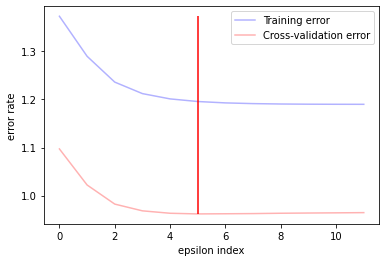

Best cross-validation error: 0.9618832442226553
epsilon giving the lowest error: 6


In [19]:
train_errors = []
cv_errors = []

for epsilon in epsilons:
    huber = HuberRegressor(max_iter=max_iter, epsilon=epsilon)

    # Fit the polynomial model
    huber.fit(X_train, y_train)

    # Predict the labels and get the training error
    y_pred_train = huber.predict(X_train)
    train_error = mean_squared_error(y_train, y_pred_train)

    # Predict the cv labels and count the cross-validation error
    y_pred_cv = huber.predict(X_cv)
    cv_error = mean_squared_error(y_cv, y_pred_cv)

    # Append the error scores
    train_errors.append(train_error)
    cv_errors.append(cv_error)

print(f"train_errors: {train_errors}")
print(f"cv_errors: {cv_errors}")

plot_errors(train_errors, cv_errors, epsilons)

#### Step 3.3: Ridge Regression
Loss: Mean squared error loss regularised by L2-norm

train_errors: [1.1899031039680126, 1.1899031040849541, 1.1899031054135014, 1.1899031170503829, 1.1899032477845808, 1.1899043564970455, 1.189915568857942, 1.1899880472666013, 1.1903718092901643, 1.1913806537551273, 1.1940445089553278]
cv_errors: [0.9651179778149314, 0.9651179835612841, 0.9651180041633709, 0.9651180672017267, 0.9651183356431403, 0.965119490150395, 0.9651272910692164, 0.96516827465605, 0.9653344874526268, 0.9655377571443939, 0.9656416968172652]


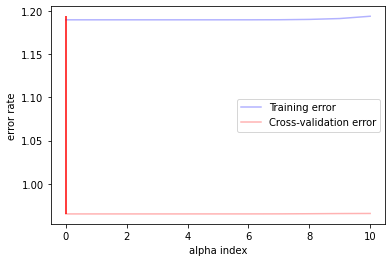

Best cross-validation error: 0.9651179778149314
alpha giving the lowest error: 0.0001


In [8]:
train_errors = []
cv_errors = []

for alpha in alphas:
    ridge = Ridge(max_iter=max_iter, alpha=alpha)

    # Fit the polynomial model
    ridge.fit(X_train, y_train)

    # Predict the labels and get the training error
    y_pred_train = ridge.predict(X_train)
    train_error = mean_squared_error(y_train, y_pred_train)

    # Predict the cv labels and count the cross-validation error
    y_pred_cv = ridge.predict(X_cv)
    cv_error = mean_squared_error(y_cv, y_pred_cv)

    # Append the error scores
    train_errors.append(train_error)
    cv_errors.append(cv_error)

print(f"train_errors: {train_errors}")
print(f"cv_errors: {cv_errors}")

plot_errors(train_errors, cv_errors, alphas)

#### Step 3.4: Lasso Regresssion
Mean squared error loss regularised by L1-norm

train_errors: [1.1908867156733547, 1.19252592703466, 1.1998793774939793, 1.228350642415734, 1.2877733149122, 1.3613955312340147, 1.4261278585407973, 1.4261278585407973, 1.4261278585407973, 1.4261278585407973, 1.4261278585407973]
cv_errors: [0.9659695120536096, 0.9665335636774143, 0.9689891268831551, 0.9818023107586255, 1.0324838139661279, 1.0984698876267711, 1.142770581919855, 1.142770581919855, 1.142770581919855, 1.142770581919855, 1.142770581919855]


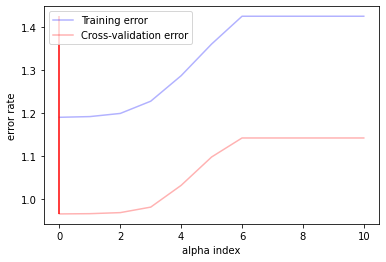

Best cross-validation error: 0.9659695120536096
alpha giving the lowest error: 0.0001


In [9]:
train_errors = []
cv_errors = []
    
for alpha in alphas:
    lasso = Lasso(max_iter=max_iter, alpha=alpha)

    # Fit the polynomial model
    lasso.fit(X_train, y_train)

    # Predict the labels and get the training error
    y_pred_train = lasso.predict(X_train)
    train_error = mean_squared_error(y_train, y_pred_train)

    # Predict the cv labels and count the cross-validation error
    y_pred_cv = lasso.predict(X_cv)
    cv_error = mean_squared_error(y_cv, y_pred_cv)

    # Append the error scores
    train_errors.append(train_error)
    cv_errors.append(cv_error)

print(f"train_errors: {train_errors}")
print(f"cv_errors: {cv_errors}")

plot_errors(train_errors, cv_errors, alphas)

### Step 4: Model picking and testing
Based on the cross-validation error, the best model seems to be ridge regression with alpha set to 1. Let's train this model one more time and then try test it out in our test set.

In [20]:
def plot_predictions(y_actual, y_pred):
    plt.plot(y_actual, color="r", alpha=0.5)
    plt.plot(y_pred, color="b", alpha=0.5)
    plt.legend(["Real Data", "Predictions"])
    plt.show()
    
    test_error = mean_squared_error(y_test, y_pred_test)    
    print(f"Test error: {test_error}")

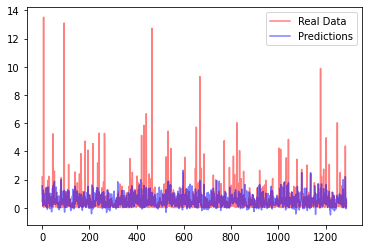

Test error: 1.0199992963398945


In [22]:
model = HuberRegressor(max_iter=max_iter, epsilon=6)

model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)

plot_predictions(y_test, y_pred_test)

### Conclusion
Model seems to predict the sales prices relatively well. The dataset contains quite a few outliers that the model has hard time predicting but despite this the model seems to find the baseline of the sales pretty well.

This races the question if the four features by themselves are even capable of predicting the global sales. There are many other things that go into game development and sales, for example the quality of content in the game: is the game fun to play, are there lots of bugs, does the game have an active and engaging community behind it? These aspects are completely left out but they have a massive impact on how well the game ends up selling.

Interesting features to include in the dataset would be e.g the Metacritic rating (experts vs community) and release month. The public perception of the game often has great impact on after-release sales. Also, many game publishers try to target to release their games during holiday season, probably, because this often leads to greater sales. These two features would likely give much better understanding of the problem which consequently would lead to better models to predict the global sales.